# SVM Classification and Visualization

## 1. Imports and Dependencies
In this block, we import all of the Python packages and modules required for data handling, model training, evaluation, and visualization.  
- **NumPy** and **Pandas** for numerical arrays and DataFrame manipulation.  
- **Matplotlib** and **Seaborn** for static 2D plots (heatmaps, confusion matrices, dendrograms).  
- **scikit-learn**’s `SVC` for the Support Vector Machine, plus metric functions (`accuracy_score`, `precision_score`, etc.) to evaluate performance.  
- **PCA** from `sklearn.decomposition` to reduce high-dimensional embeddings to 3D for plotting.  
- **SciPy**’s hierarchical clustering tools (`linkage`, `dendrogram`) to build and draw a class-centroid tree.  
- **Plotly Express** for an interactive 3D scatter plot of the test data projections.

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
import plotly.express as px

## 2. Loading the Precomputed Embeddings
Here we load the `.npz` archive containing ResNet-101 feature embeddings and their labels for training, validation, and testing. The arrays are unpacked into `X_*` for feature matrices and `y_*` for label vectors. We also grab `class_names` for human-readable labels in reports and plots.


In [4]:
# Load embedding data
data = np.load("galaxy10_resnet101_embeddings_augmented_balanced_regularized.npz", allow_pickle=True)
X_train = data['train_features']
y_train = data['train_labels']
X_val = data['val_features']
y_val = data['val_labels']
X_test = data['test_features']
y_test = data['test_labels']
class_names = data['class_names']


## 3. Hyperparameter Grid Search
This section performs a simple grid search over two SVM hyperparameters—`C` (regularization strength) and `gamma` (RBF kernel width). For each combination, the model is trained on the training set, evaluated on the validation set, and the resulting accuracy is stored in a list. Finally, we convert these results into a DataFrame for inspection.


In [5]:
# Hyperparameter search for SVM (RBF kernel)
C_values = [0.1, 1, 10, 100]
gamma_values = ['scale', 'auto']
results = []
for C in C_values:
    for gamma in gamma_values:
        svm = SVC(kernel='rbf', C=C, gamma=gamma, random_state=42)
        svm.fit(X_train, y_train)
        y_val_pred = svm.predict(X_val)
        acc = accuracy_score(y_val, y_val_pred)
        results.append({'C': C, 'gamma': gamma, 'accuracy': acc})
results_df = pd.DataFrame(results)
print(results_df)

       C  gamma  accuracy
0    0.1  scale  0.872744
1    0.1   auto  0.874885
2    1.0  scale  0.873356
3    1.0   auto  0.874273
4   10.0  scale  0.872438
5   10.0   auto  0.875497
6  100.0  scale  0.867238
7  100.0   auto  0.872744


## 4. Visualizing Validation Accuracy
To help choose the best hyperparameters, we pivot the grid-search results into a matrix (rows = `C`, columns = `gamma`) and draw a heatmap. Annotating each cell with its accuracy makes it easy to spot the top-performing combination at a glance.


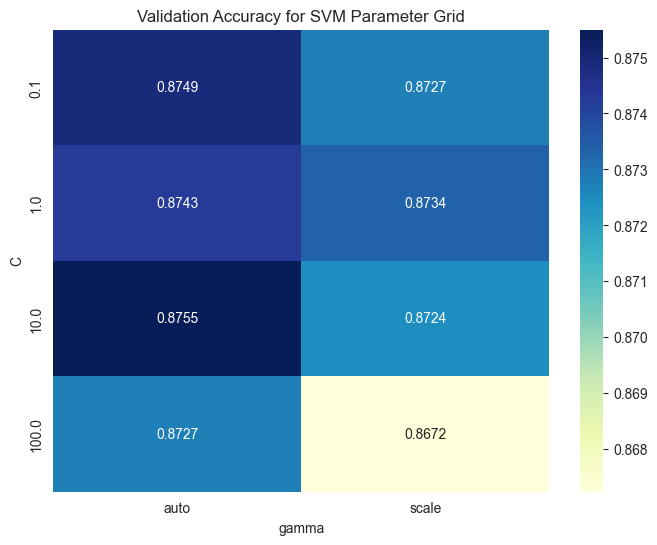

In [6]:
# Plot validation accuracy heatmap
results_pivot = results_df.pivot(index='C', columns='gamma', values='accuracy')
plt.figure(figsize=(8, 6))
sns.heatmap(results_pivot, annot=True, fmt='.4f', cmap='YlGnBu')
plt.title('Validation Accuracy for SVM Parameter Grid')
plt.ylabel('C')
plt.xlabel('gamma')
plt.show()

## 5. Selecting the Best Hyperparameters
This short block locates the grid-search row with the highest validation accuracy, extracts its `C` and `gamma` values, and prints them. These will be used for the final model training.


In [7]:
# Select best hyperparameters
best = results_df.loc[results_df['accuracy'].idxmax()]
best_C = best['C']
best_gamma = best['gamma']
print(f"Best parameters -> C: {best_C}, gamma: {best_gamma}")


Best parameters -> C: 10.0, gamma: auto


## 6. Final Model Training and Prediction
Using the best hyperparameters found, we train one final SVM on the entire training set, then predict labels on the held-out test set. The predicted labels (`y_pred`) will be used for all downstream evaluation.


In [8]:
svm_final = SVC(kernel='rbf', C=best_C, gamma=best_gamma, random_state=42)
svm_final.fit(X_train, y_train)
y_pred = svm_final.predict(X_test)

# 7. Computing Core Evaluation Metrics
We calculate key scalar metrics on the test set to quantify overall performance:  
- **Accuracy** (overall fraction correct)  
- **Balanced Accuracy** (average recall across classes)  
- **Macro-averaged Precision, Recall, F1** (treat each class equally, helpful when classes are imbalanced)


In [9]:
acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f"Accuracy: {acc:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1 Score: {f1:.4f}")

Accuracy: 0.8828
Balanced Accuracy: 0.7542
Macro Precision: 0.7781
Macro Recall: 0.7542
Macro F1 Score: 0.7645


## 8. Detailed Per-Class Report
The `classification_report` printout shows precision, recall, F1, and support (number of true samples) for each galaxy class, making it easy to see which classes are most confused.


In [10]:
print(classification_report(y_test, y_pred, target_names=class_names, digits=4, zero_division=0))


                   precision    recall  f1-score   support

    barred_spiral     0.8074    0.8015    0.8044       136
     cigar_smooth     0.8933    0.9131    0.9031       944
  edgeon_no_bulge     0.8750    0.6731    0.7609        52
edgeon_with_bulge     0.9053    0.9565    0.9302       230
 inbetween_smooth     0.9339    0.9419    0.9379      1050
           merger     0.8250    0.8462    0.8354        78
     round_smooth     0.7771    0.7592    0.7680       519
     spiral_loose     0.8831    0.8095    0.8447       168
    spiral_medium     0.8810    0.8409    0.8605        88
     spiral_tight     0.0000    0.0000    0.0000         3

         accuracy                         0.8828      3268
        macro avg     0.7781    0.7542    0.7645      3268
     weighted avg     0.8816    0.8828    0.8818      3268



## 9. Confusion Matrix Visualization
We render a labeled confusion matrix using `ConfusionMatrixDisplay`. This plot highlights which true–predicted class pairs are most frequent, revealing systematic misclassifications.


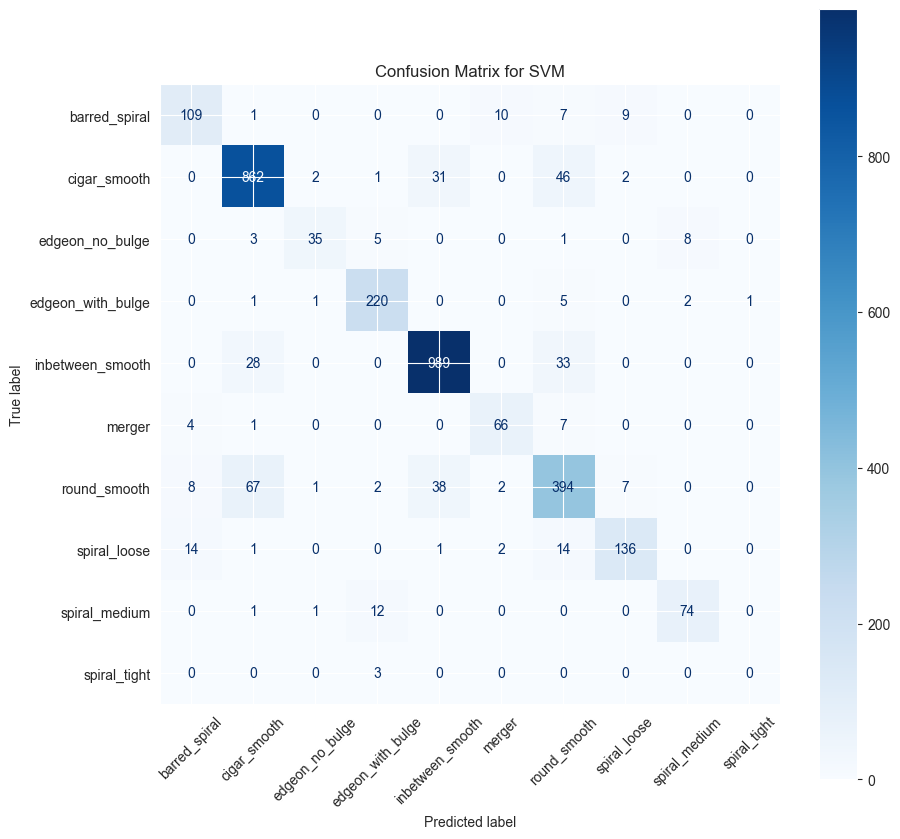

In [11]:
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
display.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix for SVM')
plt.show()

## 10. 3D PCA Scatter of Test Embeddings
To visually inspect class separability, we reduce the 2048-dimensional embeddings to 3 principal components and plot them in an interactive 3D scatter. Points are colored by the model’s predicted class.


In [12]:
# 3D PCA visualization of test set
pca_vis = PCA(n_components=3, random_state=42)
X_vis = pca_vis.fit_transform(X_test)
df_vis = pd.DataFrame({
    'PC1': X_vis[:, 0],
    'PC2': X_vis[:, 1],
    'PC3': X_vis[:, 2],
    'Prediction': [class_names[i] for i in y_pred]
})
fig_vis = px.scatter_3d(df_vis, x='PC1', y='PC2', z='PC3', color='Prediction',
                        title='3D PCA of Test Set Embeddings (SVM Predictions)', width=800, height=600)
fig_vis.update_traces(marker=dict(size=4, opacity=0.7))
fig_vis.show()

## 11. Hierarchical Clustering of Class Centroids
Finally, we compute the average embedding (“centroid”) for each predicted class, then run a Ward linkage hierarchical clustering on those centroids. The resulting dendrogram shows which galaxy types are closest in feature space.


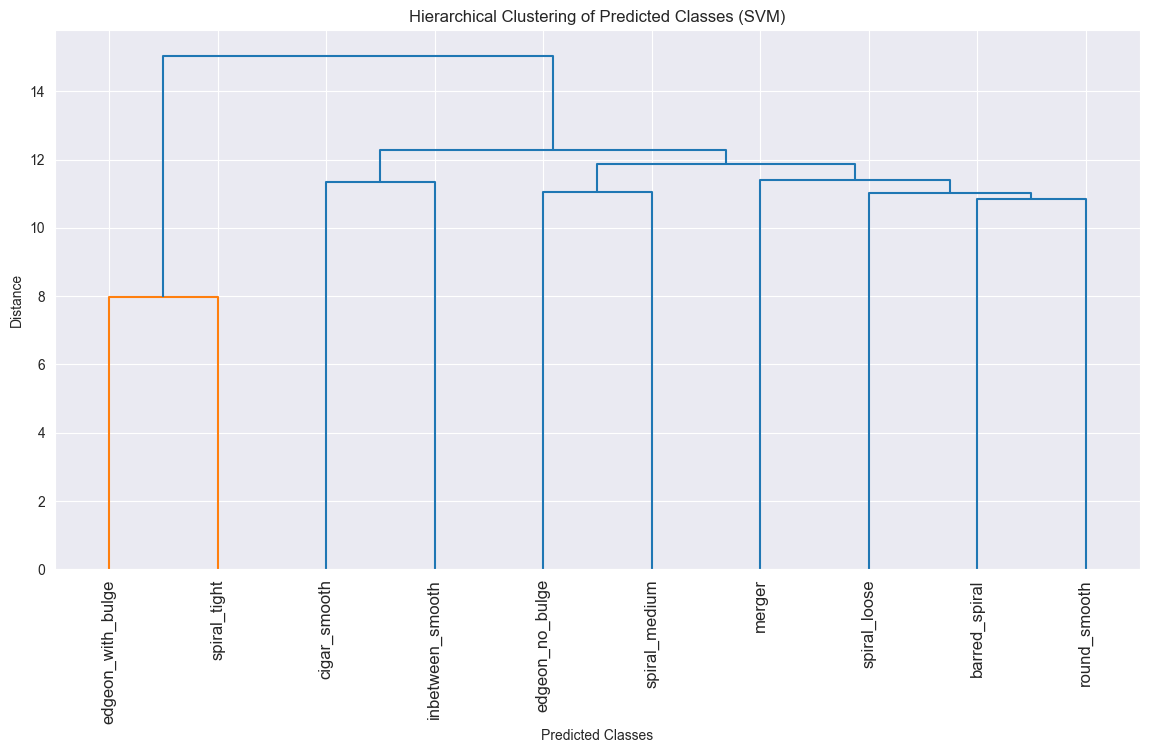

In [13]:
# Hierarchical clustering of predicted class centroids
centroids = []
valid_class_names = []
for cls in range(len(class_names)):
    idx = np.where(y_pred == cls)[0]
    if len(idx) == 0:
        print(f"Skipping class {class_names[cls]}: no test samples predicted.")
        continue
    centroids.append(np.mean(X_test[idx], axis=0))
    valid_class_names.append(class_names[cls])
centroids = np.array(centroids)
valid_class_names = np.array(valid_class_names)
linked = linkage(centroids, method='ward')
plt.figure(figsize=(14, 7))
dendrogram(linked, labels=valid_class_names, leaf_rotation=90)
plt.title('Hierarchical Clustering of Predicted Classes (SVM)')
plt.xlabel('Predicted Classes')
plt.ylabel('Distance')
plt.show()